In [1]:
import torch

In [2]:
import matplotlib.pyplot as plt
import torch
from einops import rearrange
from controllable_nca.dataset import NCADataset
from controllable_nca.utils import load_emoji, rgb

def plot_img(img):
    with torch.no_grad():
        rgb_image = rgb(img, False).squeeze().detach().cpu().numpy()
    rgb_image = rearrange(rgb_image, "c w h -> w h c")
    _ = plt.imshow(rgb_image)
    plt.show()


In [3]:
import matplotlib.pyplot as plt
import torch
from einops import rearrange
from controllable_nca.dataset import NCADataset

from controllable_nca.dataset import MultiClass2DDataset
from controllable_nca.utils import load_emoji, rgb
import torch.nn.functional as F

class EmojiDataset(MultiClass2DDataset):
    # EMOJI = '🦎😀💥'
    EMOJI = "🦎"

    def __init__(self, image_size=48, padding=16):
        center = F.pad(
            torch.stack(
                [load_emoji(e, image_size) for e in EmojiDataset.EMOJI], dim=0
            ),
            (padding // 2, padding // 2, padding // 2, padding // 2, 0, 0)
        )
        left = F.pad(center, (0, padding, 0, 0, 0, 0, 0, 0))[:, :, :, padding:]
        right = F.pad(center, (padding, 0, 0, 0, 0, 0, 0, 0))[:, :, :, :-padding]
        emojis = torch.stack([center,left,right]).squeeze()
        self.padding = padding
        targets = torch.arange(emojis.size(0))
        super(EmojiDataset, self).__init__(emojis, targets, use_one_hot=True)

    def visualize(self, idx=0):
        self.plot_img(self.x[idx : idx + 1])

    def plot_img(self, img):
        with torch.no_grad():
            rgb_image = rgb(img, False).squeeze().detach().cpu().numpy()
        rgb_image = rearrange(rgb_image, "c w h -> w h c")
        _ = plt.imshow(rgb_image)
        plt.show()


In [4]:
def draw_in_grid(img, x = None, y = None, grid_size = 64):
    with torch.no_grad():
        if x is None:
            x = grid_size // 2
        if y is None:
            y = grid_size // 2

        img_size = img.size(-1)
        center = img_size // 2
        grid = torch.zeros(1, img.size(1), grid_size, grid_size, device=img.device)

        min_x = x - center
        min_x_diff = 0 - min(0, min_x)
        max_x = x + center
        max_x_diff = grid_size - max(64, max_x)
        min_x = min_x + max_x_diff + min_x_diff
        max_x = max_x + max_x_diff + min_x_diff

        min_y = y - center
        min_y_diff = 0 - min(0, min_y)
        max_y = y + center
        max_y_diff = grid_size - max(grid_size, max_y)
        min_y = min_y + max_y_diff + min_y_diff
        max_y = max_y + max_y_diff + min_y_diff

        grid[:, :, min_x:max_x, min_y:max_y] += img
        return grid, (min_x + center, min_y + center)

class EmojiPlacementDataset(NCADataset):
    EMOJI = "🦎"

    def __init__(self, grid_size=64, image_size=32):
        super().__init__()
        self.grid_size = grid_size
        self.image_size = image_size
        self.x = load_emoji(EmojiPlacementDataset.EMOJI, image_size).unsqueeze(0)

    def draw(self, x=None, y=None, substrate=None):
        if substrate is None:
            substrate = self.x
        return draw_in_grid(substrate.clone(), x=x,y=y, grid_size=self.grid_size)

    def target_size(self):
        return (4, self.grid_size, self.grid_size)

    def visualize(self, x=None, y=None):
        grid, coords = self.draw(x,y)
        plot_img(grid)
        
    def to(self, device: torch.device):
        self.x = self.x.to(device)

In [5]:
dataset = EmojiPlacementDataset()

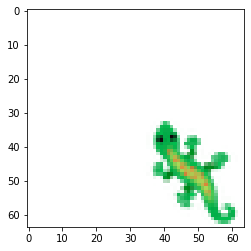

In [6]:
dataset.visualize(48, 48)

In [7]:
from controllable_nca.image.nca import ControllableImageNCA


In [8]:
import math
import random
from typing import Any, Optional, Tuple  # noqa

import numpy as np
import torch
import torch.nn.functional as F
import tqdm

from controllable_nca.dataset import NCADataset
from controllable_nca.image.nca import ControllableImageNCA
from controllable_nca.sample_pool import SamplePool
from controllable_nca.trainer import NCATrainer
from controllable_nca.utils import create_2d_circular_mask


class ControllableNCAImageTrainer(NCATrainer):
    def __init__(
        self,
        nca: ControllableImageNCA,
        target_dataset: NCADataset,
        nca_steps=[48, 96],
        lr: float = 2e-3,
        pool_size: int = 512,
        num_damaged: int = 0,
        log_base_path: str = "tensorboard_logs",
        damage_radius: int = 3,
        device: Optional[torch.device] = None,
    ):
        super(ControllableNCAImageTrainer, self).__init__(
            pool_size, num_damaged, log_base_path, device
        )
        self.target_dataset = target_dataset
        self.target_size = self.target_dataset.target_size()

        self.nca = nca
        self.min_steps = nca_steps[0]
        self.max_steps = nca_steps[1]

        self.num_target_channels = self.target_size[0]
        self.image_size = self.target_size[-1]
        self.rgb = self.target_size[0] == 3
        self.damage_radius = damage_radius

        self.optimizer = torch.optim.Adam(self.nca.parameters(), lr=lr)
        self.lr_sched = torch.optim.lr_scheduler.MultiStepLR(
            self.optimizer, [5000], 0.3
        )

    def to_alpha(self, x):
        return torch.clamp(x[:, 3:4, :, :], 0.0, 1.0)  # 1.0

    def to_rgb(self, x):
        # assume rgb premultiplied by alpha
        if self.rgb:
            return torch.clamp(x[:, :3], 0.0, 1.0).detach().cpu().numpy()
        rgb = x[:, :3, :, :]  # 0,0,0
        a = self.to_alpha(x)  # 1.0
        im = 1.0 - a + rgb  # (1-1+0) = 0, (1-0+0) = 1
        im = torch.clamp(im, 0, 1)
        return im.detach().cpu().numpy()

    def loss(self, x, targets):
        return F.mse_loss(
            x[:, : self.num_target_channels, :, :], targets[:, : self.num_target_channels, :, :], reduction="none"
        ).mean(dim=(1, 2, 3))

    def sample_batch(self, sampled_indices, sample_pool = None, replace=2) -> Tuple[Any, Any]:
        """
        Returns batch + targets

        Returns:
            Tuple[Any, Any]: [description]
        """
        default_coords = (self.target_dataset.grid_size // 2, self.target_dataset.grid_size // 2)
        if sample_pool is not None:
            batch = sample_pool[sampled_indices]
        else:
            batch = [None for _ in range(len(sampled_indices))]
        for i in range(len(sampled_indices)):
            if batch[i] is None:
                batch[i] = (self.nca.generate_seed(1)[0].to(self.device), default_coords)
            elif torch.sum(self.nca.alive(batch[i][0].unsqueeze(0))) == 0.0:
                batch[i] = (self.nca.generate_seed(1)[0].to(self.device), default_coords)
        for i in range(replace):
            batch[-i] = (self.nca.generate_seed(1)[0].to(self.device), default_coords)
        return batch

    def sample_targets(self, batch_coords, directions, steps, substrates):
        out_targets = []
        goals = []
        out_coords = []
        
        for coords, direction, num_steps, substrate in zip(batch_coords, directions, steps, substrates):
            if direction == 0:
                # stay in place
                new_coords = coords
            if direction == 1:
                # left
                new_coords = (coords[0] - (num_steps // 8), coords[1])
            if direction == 2:
                # right
                new_coords = (coords[0] + (num_steps // 8), coords[1])
            if direction == 3:
                # up
                new_coords = (coords[0], coords[1] - (num_steps // 8))
            if direction == 4:
                # down
                new_coords = (coords[0], coords[1] + (num_steps // 8))
            sub = substrate

            if sub is not None:
#                 zeros = torch.zeros(sub.size(), device=sub.device)
#                 shift = num_steps // 16
#                 if direction == 0:
#                     # stay in place
#                     zeros = sub.detach()
#                 if direction == 1:
#                     # left
                    
#                     zeros[
#                     new_coords = (coords[0] - (num_steps // 16), coords[1])
#                 if direction == 2:
#                     # right
#                     new_coords = (coords[0] + (num_steps // 16), coords[1])
#                 if direction == 3:
#                     # up
#                     new_coords = (coords[0], coords[1] - (num_steps // 16))
#                 if direction == 4:
#                     # down
#                     new_coords = (coords[0], coords[1] + (num_steps // 16))
                x,y = coords
                min_x = x - 16
                min_x_diff = 0 - min(0, min_x)
                max_x = x + 16
                max_x_diff = 64 - max(64, max_x)
                min_x = min_x + max_x_diff + min_x_diff
                max_x = max_x + max_x_diff + min_x_diff

                min_y = y - 16
                min_y_diff = 0 - min(0, min_y)
                max_y = y + 16
                max_y_diff = 64 - max(64, max_y)
                min_y = min_y + max_y_diff + min_y_diff
                max_y = max_y + max_y_diff + min_y_diff

                sub = substrate[:, min_x:max_x, min_y:max_y].clone()
                sub = sub.unsqueeze(0)

            target, new_coords = self.target_dataset.draw(new_coords[0], new_coords[1], sub)

            goals.append(torch.tensor(direction, device=self.device))            
            out_coords.append(new_coords)
            out_targets.append(target)
        
        return out_coords, out_targets, goals

    def train_batch(self, batch, directions, num_steps, use_substrate_as_targets = False):
        coords = []
        substrates = []
        steps = [num_steps]*len(batch)
        for i in range(len(batch)):
            substrate, batch_coords = batch[i]
            substrates.append(substrate.to(self.device))
            coords.append(batch_coords)
        if use_substrate_as_targets:
            new_coords, targets, goals = self.sample_targets(coords, directions, steps, substrates=substrates)
        else:
            new_coords, targets, goals = self.sample_targets(coords, directions, steps, substrates=[None]*len(batch))

        substrates = torch.stack(substrates, dim=0).squeeze()
        targets = torch.stack(targets, dim=0).squeeze().to(self.device)
        goals  = self.nca.encoder(torch.stack(goals, dim=0).squeeze().to(self.device))

        substrates = self.nca.grow(substrates, num_steps=num_steps, goal=goals)
        if not use_substrate_as_targets:
            loss = self.loss(substrates, targets).mean()
        else:
            loss = self.loss(substrates, targets).mean()
            # loss = F.mse_loss(
            #     substrates, targets, reduction="none"
            # ).mean(dim=(1, 2, 3)).mean()
        loss = self.loss(substrates, targets).mean()
        self.optimizer.zero_grad()
        loss.backward()
        for p in self.nca.parameters():
            if p.grad is not None:
                p.grad /= torch.norm(p.grad) + 1e-10
        self.optimizer.step()
        grad_dict = {}
        for n, W in self.nca.named_parameters():
            if W.grad is not None:
                grad_dict["{}_grad".format(n)] = float(torch.sum(W.grad).item())

        return (
            substrates.detach(),
            list(zip(list(substrates.detach().cpu()), new_coords)),
            targets,
            loss.item(),
            {"loss": loss.item(), "log10loss": math.log10(loss.item()), **grad_dict},
        )

#     def train_batch(self, batch, targets, goals):
#         batch = self.nca.grow(batch, num_steps=num_steps, goal=goals)
#         loss = self.loss(batch, target_images).mean()
#         self.optimizer.zero_grad()
#         loss.backward()
#         for p in self.nca.parameters():
#             if p.grad is not None:
#                 p.grad /= torch.norm(p.grad) + 1e-10
#         self.optimizer.step()
#         self.lr_sched.step()
#         grad_dict = {}
#         for n, W in self.nca.named_parameters():
#             if W.grad is not None:
#                 grad_dict["{}_grad".format(n)] = float(torch.sum(W.grad).item())

#         return (
#             batch.detach(),
#             loss.item(),
#             {"loss": loss.item(), "log10loss": math.log10(loss.item()), **grad_dict},
#         )

    def train(self, batch_size, epochs):
        bar =  tqdm.tqdm(range(epochs))
        self.pool = SamplePool(self.pool_size)

        for i in bar:
            idxs = random.sample(range(self.pool_size), batch_size)
            
            with torch.no_grad():
                batch = self.sample_batch(idxs, self.pool, replace=4)

            # train center
            directions = [0]*batch_size
            num_steps = np.random.randint(self.min_steps, self.max_steps)
            substrates, new_batch, center_targets,  loss, metrics = self.train_batch(batch, directions, num_steps)
            
#             # train small random directions
            directions = np.random.randint(1, 5, batch_size)
            substrates, small_steps_batch, small_targets, loss, metrics = self.train_batch(new_batch, directions, 32, use_substrate_as_targets=False)
            substrates, med_steps_batch, med_targets, loss, metrics = self.train_batch(small_steps_batch, directions, 32, use_substrate_as_targets=False)
            # substrates, med_steps_batch, med_targets, loss, metrics = self.train_batch(small_steps_batch, directions, 1, use_substrate_as_targets=False)
            substrates, large_steps_batch, large_targets, loss, metrics = self.train_batch(med_steps_batch, directions, 32, use_substrate_as_targets=False)
#             # train medium random directions
#             directions = np.random.randint(1, 5, batch_size)
            self.pool[idxs] = small_steps_batch
#             # train large random directions
#             directions = np.random.randint(1, 5, batch_size)
#             substrates, large_steps_batch, large_targets, loss, metrics = self.train_batch(med_steps_batch, directions, 8)

#             # train largest random directions
#             directions = np.random.randint(1, 5, batch_size)
#             substrates, largest_steps_batch, largest_targets, loss, metrics = self.train_batch(large_steps_batch, directions, 8)

            self.lr_sched.step()

            description = "--".join(["{}:{}".format(k, metrics[k]) for k in metrics])
            bar.set_description(description)
            outputs = [
                ("sampled_batch", batch, None),
                ("centered", new_batch, center_targets),
                ("small", small_steps_batch, small_targets),
                ("med", med_steps_batch, med_targets),
                ("large", large_steps_batch, large_targets)
            ]
            self.emit_metrics(i, outputs, metrics)


    def emit_metrics(self, i: int, outputs, metrics={}):
        with torch.no_grad():
            for o in outputs:
                keys, batch, targets = o
                batch = [b[0].detach().cpu() for b in batch]
                batch = torch.stack(batch, dim=0)
                self.train_writer.add_images(
                    keys + "_batch", self.to_rgb(batch), i, dataformats="NCHW"
                )
                if targets is not None:
                    self.train_writer.add_images(
                        keys + "_targets", self.to_rgb(targets), i, dataformats="NCHW"
                    )


            for k in metrics:
                self.train_writer.add_scalar(k, metrics[k], i)
            

#     def train(self, batch_size, epochs, *args, **kwargs):
#         self.pool = SamplePool(self.pool_size)
#         bar = tqdm.tqdm(range(epochs))
#         for i in bar:
#             # Sort by loss, descending.
#             idxs = random.sample(range(len(self.pool)), batch_size)
#             with torch.no_grad():
#                 targets, goal_vectors = self.sample_targets([0]*batch_size)
#                 batch = self.sample_batch(idxs, self.pool)
#                 batch[: (batch_size // 3)] = self.nca.generate_seed(batch_size // 3).to(
#                     self.device
#                 )

#             # grow centered
#             outputs, loss, metrics = self.train_batch(batch, targets)
#             # train more
#             outputs, loss, metrics = self.train_batch(batch, targets)
            
#             # switch goals
#             with torch.no_grad():
#                 targets, random_indices = self.sample_targets(idxs)
#             outputs, loss, metrics = self.train_batch(outputs, targets)
#             # train more
#             outputs, loss, metrics = self.train_batch(outputs, targets)

#             # Place outputs back in the pool.
#             self.update_pool(idxs, outputs, targets)
#             description = "--".join(["{}:{}".format(k, metrics[k]) for k in metrics])
#             bar.set_description(description)
#             self.emit_metrics(i, batch, outputs, targets[0], loss, metrics=metrics)


In [9]:
from torch.nn import Embedding
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, num_embeddings: int, out_channels: int, embedding_dim: int = 32):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.embedding = Embedding(num_embeddings, out_channels)
#         self.encoder = nn.Sequential(
#             nn.Linear(embedding_dim, 64),
#             nn.Tanh(),
#             nn.Linear(64, out_channels)
#         )
    
    def forward(self, indices):
        embeddings = self.embedding(indices)
        return embeddings

In [10]:
NUM_HIDDEN_CHANNELS = 32

encoder = Encoder(5, NUM_HIDDEN_CHANNELS, 32)
nca =  ControllableImageNCA(target_shape=dataset.target_size(), encoder = encoder, living_channel_dim=3, num_hidden_channels=NUM_HIDDEN_CHANNELS, cell_fire_rate=1.0)

In [11]:
device = torch.device('cuda')
nca = nca.to(device)
dataset.to(device)

In [12]:
trainer = ControllableNCAImageTrainer(nca, dataset, nca_steps=[48, 64], lr=1e-3, num_damaged=0, damage_radius=3, device=device, pool_size=1024)

Writing to tensorboard_logs/2022-02-18 07:12:16.832004


In [13]:
# trainer.train(batch_size=24, epochs=100000)

In [14]:
from threading import Event, Thread

import cv2
import numpy as np
import torch
from einops import rearrange
from ipycanvas import Canvas, hold_canvas  # noqa
from ipywidgets import Button, HBox, VBox

from controllable_nca.utils import create_2d_circular_mask, rgb


def to_numpy_rgb(x, use_rgb=False):
    return rearrange(
        np.squeeze(rgb(x, use_rgb).detach().cpu().numpy()), "c x y -> x y c"
    )


class ControllableNCAImageVisualizer:
    def __init__(
        self,
        trainer,
        image_size,
        rgb: bool = False,
        canvas_scale=5,
        damage_radius: int = 5,
    ):
        self.trainer = trainer
        self.current_state = None
        self.current_embedding = None

        self.image_size = image_size
        self.rgb = rgb
        self.canvas_scale = canvas_scale
        self.canvas_size = self.image_size * self.canvas_scale

        self.canvas = Canvas(width=self.canvas_size, height=self.canvas_size)
        self.canvas.on_mouse_down(self.handle_mouse_down)
        self.stopped = Event()

        x = self.trainer.target_dataset.x
        # with torch.no_grad():
        #     self.embeddings = self.trainer.target_dataset.one_hot
        self.current_embedding = self.trainer.nca.encoder(torch.tensor(0, device=self.trainer.device))

        self.device = self.trainer.device
        self.damage_radius = damage_radius
        self.current_state = self.trainer.nca.generate_seed(1).to(self.device)
        
        def button_fn(class_num):
            def start(btn):
                self.current_embedding = self.trainer.nca.encoder(torch.tensor(class_num, device=self.trainer.device))
                if self.stopped.isSet():
                    self.stopped.clear()
                    Thread(target=self.loop).start()

            return start

        button_list = []
        for i in range(5):
            button_list.append(Button(description="{}".format(i)))
            button_list[-1].on_click(button_fn(i))

        self.vbox = VBox(button_list)

        self.stop_btn = Button(description="Stop")

        def stop(btn):
            if not self.stopped.isSet():
                self.stopped.set()

        self.stop_btn.on_click(stop)

    def handle_mouse_down(self, xpos, ypos):
        in_x = int(xpos / self.canvas_scale)
        in_y = int(ypos / self.canvas_scale)

        mask = create_2d_circular_mask(
            self.image_size,
            self.image_size,
            (in_x, in_y),
            radius=self.damage_radius,
        )
        self.current_state[0][:, mask] *= 0.0

    def draw_image(self, rgb):
        with hold_canvas(self.canvas):
            rgb = np.squeeze(rearrange(rgb, "b c w h -> b w h c"))
            self.canvas.clear()  # Clear the old animation step
            self.canvas.put_image_data(
                cv2.resize(
                    rgb * 255.0,
                    (self.canvas_size, self.canvas_size),
                    interpolation=cv2.INTER_NEAREST,
                ),
                0,
                0,
            )

    def loop(self):
        with torch.no_grad():
            self.current_state = self.trainer.nca.generate_seed(1).to(self.device)
            while not self.stopped.wait(0.02):  # the first call is in `interval` secs
                # update_particle_locations()
                self.draw_image(self.trainer.to_rgb(self.current_state))
                self.current_state = self.trainer.nca.grow(
                    self.current_state, 1, self.current_embedding
                )

    def visualize(self):
        Thread(target=self.loop).start()
        display(self.canvas, HBox([self.stop_btn, self.vbox]))  # noqa


In [15]:
nca.load("newest.pt")

In [16]:
viz = ControllableNCAImageVisualizer(trainer, 64)

In [17]:
nca

ControllableImageNCA(
  (perception_net): Conv2d(37, 111, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=37, bias=False)
  (update_net): UpdateNet(
    (out): Sequential(
      (0): Conv2d(111, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(64, 37, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (encoder): Encoder(
    (embedding): Embedding(5, 32)
  )
)

In [18]:
viz.visualize()

Canvas(height=320, width=320)